# Laboratory 5 - Systems of linear equations
#### Grzegorz Fotyga

## 1 Introduction

The aim of the following laboratory is to use various algorithms to solve systems of linear equations. The analyzed systems of equations are related to the PageRank algorithm, which was discussed in previous classes. In this laboratory, it is crucial to observe the effectiveness of individual algorithms.


### Task 1

The following code is used to generate the matrix: Edges. It contains links in a network of sites. Based on the connections, we generate matrices related to the PageRank algorithm. Solving the system of linear equations will allow you to determine the ranking of the pages (just like in the previous classes). Note - the codes below are only for generating Edges arrays. Understanding them is not necessary to complete subsequent tasks.

Generate network with 2000 sites and density of connection: 20. 

In [126]:
import numpy as np

def remove_duplicate_columns(matrix):
    unique_columns = np.unique(matrix, axis=1)
    return unique_columns

def generate_network(N, density):
    Edges = np.random.randint(1, N+1, size=(2, int(N * density)))
    Edges = np.delete(Edges, np.where(Edges[0] == Edges[1]), axis=1)
    Edges = remove_duplicate_columns(Edges)
    return Edges


n = 2000  # number of sites
density = 20  # density of connections in the network
Edges = generate_network(n, density)
print("number of connections in the network:", Edges.shape[1])  # print number of connections

number of connections in the network: 39751


### Task 2

Generate matrices related to the PageRank algorithm based on the network. Create an appropriate function that generates PageRank matrices and can be used in subsequent tasks.

In [127]:
from scipy.sparse import csr_matrix
from scipy.sparse import identity
import matplotlib.pyplot as plt 

d = 0.1  # damping factor
b = np.ones(n) * (1-d)/n
I = identity(n, format='csr')

B = csr_matrix((n,n))
B[Edges[1] - 1, Edges[0] - 1] = 1

L = np.zeros(n)
for i in range(n):
    L[i] = np.sum(B[:,i])

A = csr_matrix((n,n))
for i in range(n):
    A[i,i] = 1/L[i]

M = I - d * B @ A

### Task 3

- Solve Page Rank system of equations $\mathbf{M}\mathbf{r} = \mathbf{b}$ using *inv()* funcion from *scipy* module: $\mathbf{r} = \mathbf{M}^{-1}\mathbf{b}$. Save $\mathbf{r}$ for comparison with other methods.

- Measure the time needed for this operation (and save it for comparison with other methods).

- (and promise that this lab will be the last time you solve a system of equations this way!)

- Use function *plt.spy()* with parameter: *markersize=0.1* to observe nonzero elements of $\mathbf{M}$ and $\mathbf{M}^{-1}$ matrices. Check the memory usage of both matrices. Comment these results. 

In [128]:
from scipy.sparse.linalg import inv
import time

inv_start = time.time()

M_INV = inv(M)
r_inv = M_INV @ b

inv_end = time.time()
inv_time = inv_end - inv_start

print('Time:', inv_time)

Time: 8.392191171646118


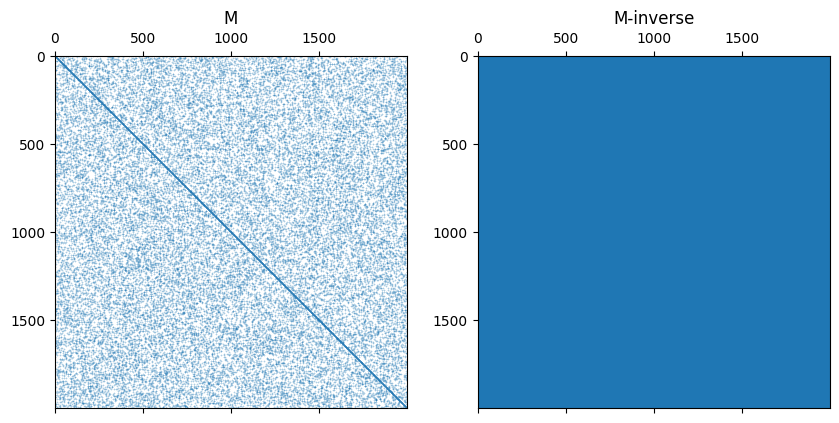

Non-zero elements in M: 41751 out of 4000000
Non-zero elements in M-inverse: 4000000 out of 4000000


In [129]:
_, (plot_M, plot_M_INV) = plt.subplots(1, 2, figsize=(10, 5))

plot_M.spy(M, markersize=0.1)
plot_M.set_title('M')

plot_M_INV.spy(M_INV, markersize=0.1)
plot_M_INV.set_title('M-inverse')

plt.show()

print('Non-zero elements in M:', M.count_nonzero(), 'out of', M.shape[0] * M.shape[1])
print('Non-zero elements in M-inverse:', M_INV.count_nonzero(), 'out of', M_INV.shape[0] * M_INV.shape[1])

In [130]:
memory_usage_M = M.data.nbytes + M.indices.nbytes + M.indptr.nbytes
print('Memory usage of M:', memory_usage_M, 'bytes')

memory_usage_M_INV = M_INV.data.nbytes + M_INV.indices.nbytes + M_INV.indptr.nbytes
print('Memory usage of M-inverse:', memory_usage_M_INV, 'bytes')

Memory usage of M: 509016 bytes
Memory usage of M-inverse: 48008004 bytes


Your comments:

Solving a 2000x2000 system using the inverse matrix method takes about **8.5s** on my machine, which is poor performance. The memory usage of $\mathbf{M}^{-1}$ is significantly worse compared to $\mathbf{M}$, since all elements of $\mathbf{M}^{-1}$ are non-zero.

### Task 4

- Solve the same system of equations using direct method: *spsolve()*. Save $\mathbf{r}$ for comparison with other methods.
- Measure the time needed for this operation (and save it for comparison with other methods).
- Use plt.plot() function to show the difference between solutions obtained in previous tasks. What is the maximum value of the difference between these vectors?
- Compute the norm (*np.linalg.norm()*) of the the difference between these two vectors. 

In [131]:
from scipy.sparse.linalg import spsolve

direct_start = time.time()

r_direct = spsolve(M, b)

direct_end = time.time()
direct_time = direct_end - direct_start

print('Time:', direct_time)

Time: 0.6840040683746338


The direct method computes the solution in less than **1s**, which is a decent result.

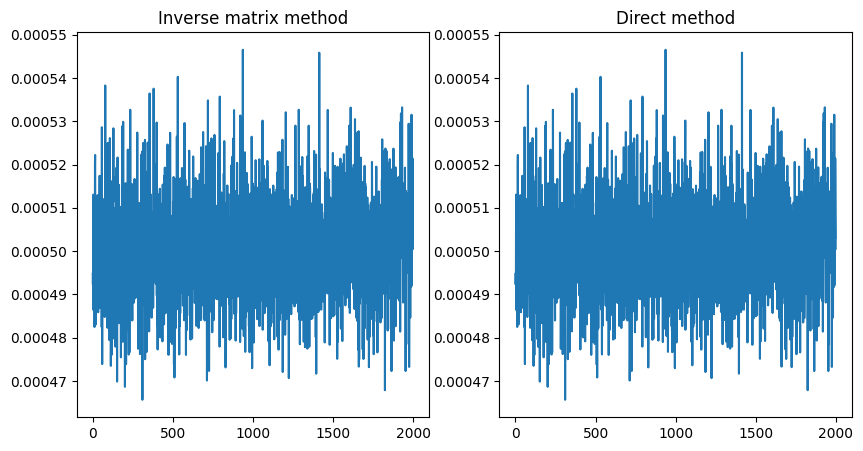

In [132]:
_, (plot_r_inv, plot_r_direct) = plt.subplots(1, 2, figsize=(10, 5))

plot_r_inv.plot(r_inv)
plot_r_inv.set_title('Inverse matrix method')

plot_r_direct.plot(r_direct)
plot_r_direct.set_title('Direct method')

plt.show()

Maximum difference: 4.336808689942018e-18


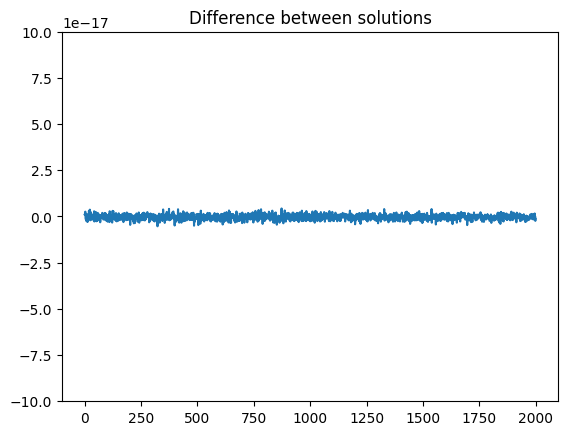

In [133]:
diff = r_inv - r_direct
print('Maximum difference:', diff.max())

plt.plot(diff)
plt.title('Difference between solutions')
plt.ylim(-1e-16, 1e-16)
plt.show()

The difference between the values in the solution vectors is extremely small. The first non-zero digit appears at the **18th decimal place**, making the difference practically irrelevant.

In [134]:
np.linalg.norm(diff)

np.float64(6.349616855918212e-17)

### Task 5

In this task you will implement Jacobi method. Firstly, split $\mathbf{M}$ into 3 components: *$\textbf{M} = -\textbf{L} - \textbf{U} + \textbf{D}$*

- $\textbf{L}$ contains all elements of $\mathbf{M}$, which lie below the diagonal (without diagonal). It can be computed using *tril()*, with parameter *k = -1*, which means that we do not include elements from diagonal. 

- $\textbf{U}$ contains all elements of $\mathbf{M}$, which lie above the diagonal (without diagonal). It can be computed using *triu()*, with parameter *k = 1*, which means that we do not include elements from diagonal. 

- $\textbf{D}$ contains all elements of $\mathbf{M}$, which lie at the diagonal. In our case it is just identity matrix. 

- Use *spy()* to observe nonzero elements. 


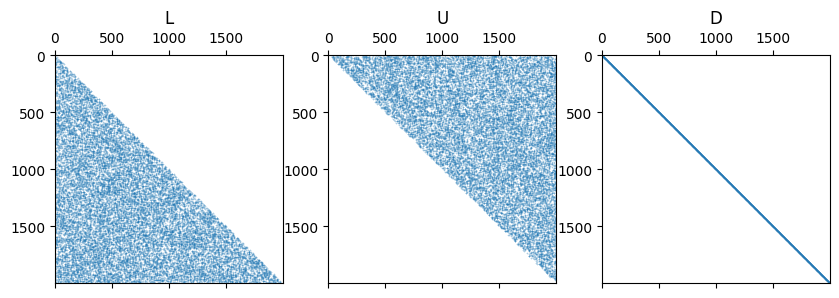

In [135]:
from scipy.sparse import triu, tril

L = tril(M, k=-1)
U = triu(M, k=1)
D = I
M = -L -U + D 

_, (plot_L, plot_U, plot_D) = plt.subplots(1, 3, figsize=(10, 5))

plot_L.spy(L, markersize=0.1)
plot_L.set_title('L')

plot_U.spy(U, markersize=0.1)
plot_U.set_title('U')

plot_D.spy(D, markersize=0.1)
plot_D.set_title('D')

plt.show()

### Task 6 - Jacobi

- Generate $\mathbf{r}^0$ vector of the same size as $\mathbf{b}$ vector, which is full of ones. It will be used as a starting vector for Jacobi scheme. 
- Use Jacobi scheme to solve system of equations in iterative way: $\widetilde{\textbf{r}}^{n+1} = \textbf{D}^{-1}(\textbf{L} + \textbf{U})\widetilde{\textbf{r}}^{n} + \textbf{D}^{-1}\textbf{b}$	

- Hint: $\mathbf{D}$ is an identity matrix. Do you need to explicitely compute $\mathbf{D}^{-1}$? 
- In each iteration compute the real error ($\textbf{e}^n = \textbf{r} - \widetilde{\textbf{r}}^{n} $, where $\textbf{r}$ is a solution obtained using the direct scheme (task 4)) and the residual error ($\textbf{res}^n = \textbf{M}\widetilde{\textbf{r}}^n - \textbf{b}$)
- Observe the NORM of these error vectors in subsequent iterations. 
- Stop iterative scheme once the NORM of the residual error falls below the value 1e-12.

In [136]:
r_jacobi, real_err_jacobi, res_err_jacobi = [np.ones_like(b) for _ in range(3)]
norm_real_jacobi = []
norm_res_jacobi = []

epsilon = 1e-12
i = 0

jacobi_start = time.time()

while True:
    r_jacobi = D @ (L + U) @ r_jacobi + D @ b

    real_err_jacobi = r_direct - r_jacobi
    res_err_jacobi = M @ r_jacobi - b

    norm_real_jacobi.append(np.linalg.norm(real_err_jacobi))
    norm_res_jacobi.append(np.linalg.norm(res_err_jacobi))

    i += 1
    
    if norm_res_jacobi[-1] < epsilon:
        break

jacobi_end = time.time()
jacobi_time = jacobi_end - jacobi_start

print('Time:', jacobi_time)
print(f'Jacobi method converged after {i} iterations')

Time: 0.014372825622558594
Jacobi method converged after 14 iterations


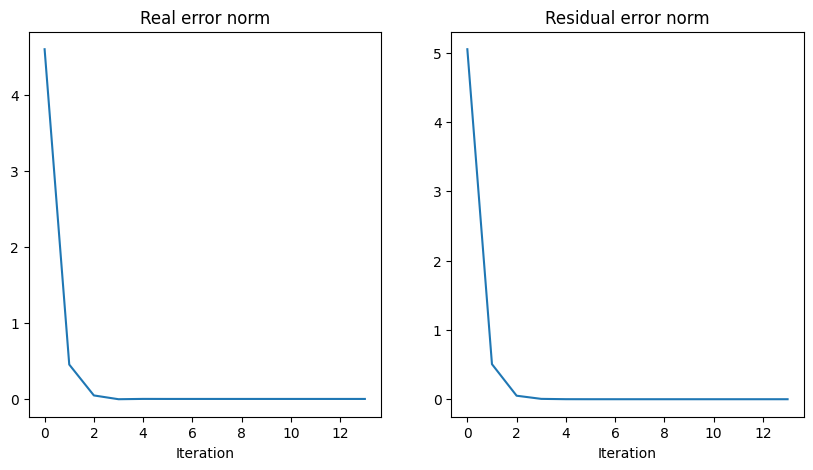

In [137]:
_, (plot_norm_real, plot_norm_res) = plt.subplots(1, 2, figsize=(10, 5))

plot_norm_real.plot(norm_real_jacobi)
plot_norm_real.set_title('Real error norm')
plot_norm_real.set_xlabel('Iteration')

plot_norm_res.plot(norm_res_jacobi)
plot_norm_res.set_title('Residual error norm')
plot_norm_res.set_xlabel('Iteration')

plt.show()

### Task 7

Compare the computational times of three methods: inv, direct and Jacobi.  

In [138]:
print('Inverse matrix method:', inv_time)
print('Direct method:', direct_time)
print('Jacobi method:', jacobi_time)

Inverse matrix method: 8.392191171646118
Direct method: 0.6840040683746338
Jacobi method: 0.014372825622558594


- The **inverse matrix method** is highly inefficient compared to direct and Jacobi methods.
- The **direct method** solves the system efficiently, providing an accurate solution.
- The **Jacobi method** quickly converges to the approximate solution, which is sufficient for most use cases (assuming convergence is guaranteed).

### Task 8 - additional

Implement Gauss-Seidel scheme.
 
$\widetilde{\textbf{r}}^{n+1} = (\textbf{D -L})^{-1}(\textbf{U} \widetilde{\textbf{r}}^{n}) + (\textbf{D -L})^{-1}\textbf{b}$

In [139]:
from scipy.sparse.linalg import spsolve_triangular

r_gauss, real_err_gauss, res_err_gauss = [np.ones_like(b) for _ in range(3)]
norm_real_gauss = []
norm_res_gauss = []

epsilon = 1e-12
i = 0

gauss_start = time.time()

while True:
    # Use forward substitution instead of inverting (D - L)
    rhs = U @ r_gauss + b
    r_gauss = spsolve_triangular(D - L, rhs, lower=True)

    real_err_gauss = r_direct - r_gauss
    res_err_gauss = M @ r_gauss - b

    norm_real_gauss.append(np.linalg.norm(real_err_gauss))
    norm_res_gauss.append(np.linalg.norm(res_err_gauss))

    i += 1

    if norm_res_gauss[-1] < epsilon:
        break

gauss_end = time.time()
gauss_time = gauss_end - gauss_start

print('Time:', gauss_time)
print(f'Gauss-Seidel method converged after {i} iterations')

Time: 0.020046234130859375
Gauss-Seidel method converged after 9 iterations


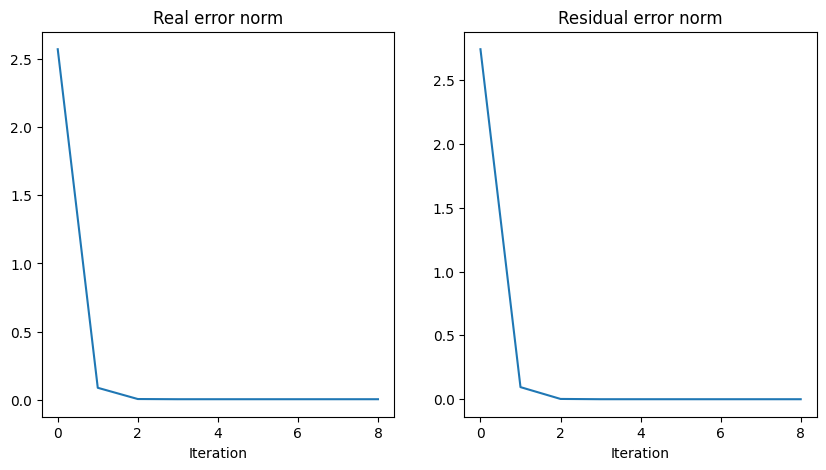

In [140]:
_, (plot_norm_real, plot_norm_res) = plt.subplots(1, 2, figsize=(10, 5))

plot_norm_real.plot(norm_real_gauss)
plot_norm_real.set_title('Real error norm')
plot_norm_real.set_xlabel('Iteration')

plot_norm_res.plot(norm_res_gauss)
plot_norm_res.set_title('Residual error norm')
plot_norm_res.set_xlabel('Iteration')

plt.show()

The Gauss–Seidel method requires fewer iterations to converge than the Jacobi method.